In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Some Reference
https://www.kaggle.com/eikedehling/tune-and-compare-xgb-lightgbm-rf-with-hyperopt
http://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html

# Dataset loading

In [2]:
dataset = pd.read_csv('../Y3 - Sample data/Z2 - datasetprepclean.csv', index_col = 0,
                     )
print('dataset shape:', dataset.shape)
dataset.head()

dataset shape: (5401, 665)


,cut_length,num_closed_patterns,num_open_patterns,total_area,minimum_rectangle_area,minimum_rectangle_dim1,minimum_rectangle_dim2,convex_hull_area,no_hole_area,thickness,...,bendlength_bend_edge_length_min_04,bendlength_bend_edge_length_max_04,weight,VAMAT,VALAJOUT,VALTOT,VOL_COST_CONVHULL,VOL_COST_RECTANGLE,VOL_COST_MPATTERN,bend_group
COART,,,,,,,,,,,,,,,,,,,,,
L1600360,3178.489502,9,0,285678.093750,431798.46875,722.070984,598.000000,320484.593750,286893.718750,4.0,...,29.010676,594.972659,13.273485,12.51,5.15,17.66,0.000010,0.000007,0.000011,3-5
L1600470,317.114502,1,0,3403.138184,3500.00000,140.000000,25.000000,3403.138184,3403.138184,10.0,...,0.000000,0.000000,0.268975,0.25,0.92,1.17,0.000007,0.000007,0.000007,0
L1600600,3710.627930,1,0,522587.812500,522587.81250,1509.000000,346.313995,522587.812500,522587.812500,3.0,...,0.000000,0.000000,12.048263,18.36,7.55,25.91,0.000012,0.000012,0.000012,1-2
L1600610,3232.627930,1,0,439818.781250,439818.78125,1270.000000,346.313995,439818.781250,439818.781250,3.0,...,0.000000,0.000000,10.140022,9.18,4.77,13.95,0.000007,0.000007,0.000007,1-2
L1600620,2972.627930,1,0,394797.968750,394797.96875,1140.000000,346.313995,394797.968750,394797.968750,3.0,...,0.000000,0.000000,9.102067,9.18,4.65,13.83,0.000008,0.000008,0.000008,1-2


In [3]:
dataset.columns.values

array(['cut_length', 'num_closed_patterns', 'num_open_patterns',
       'total_area', 'minimum_rectangle_area', 'minimum_rectangle_dim1',
       'minimum_rectangle_dim2', 'convex_hull_area', 'no_hole_area',
       'thickness', 'radius_approx', 'radius_count', 'direction_count',
       'bend_count', 'benddxf_bend_radius_00', 'benddxf_bend_angle_00',
       'benddxf_bend_direction_00', 'benddxf_deformation_length_00',
       'benddxf_merged_bend_00', 'benddxf_punch_length_00',
       'benddxf_bend_radius_01', 'benddxf_bend_angle_01',
       'benddxf_bend_direction_01', 'benddxf_deformation_length_01',
       'benddxf_merged_bend_01', 'benddxf_punch_length_01',
       'benddxf_bend_radius_02', 'benddxf_bend_angle_02',
       'benddxf_bend_direction_02', 'benddxf_deformation_length_02',
       'benddxf_merged_bend_02', 'benddxf_punch_length_02',
       'benddxf_bend_radius_03', 'benddxf_bend_angle_03',
       'benddxf_bend_direction_03', 'benddxf_deformation_length_03',
       'benddxf_mer

In [4]:
for index, nancount in dataset.isnull().sum().iteritems():
    if nancount != 0:
        print(index, '-->', nancount)
else:
    print('Done !')

dataset.shape

benddxf_deformation_length_00 --> 262
benddxf_deformation_length_01 --> 123
benddxf_deformation_length_02 --> 19
benddxf_deformation_length_03 --> 6
benddxf_deformation_length_04 --> 1
benddxf_deformation_length_05 --> 1
bendlength_deformation_length_00 --> 296
bendlength_deformation_length_01 --> 112
bendlength_deformation_length_02 --> 3
bendlength_deformation_length_03 --> 1
Done !


(5401, 665)

In [5]:
#Cleaning of the remaining Nan

subset = [x for x in dataset.columns.values if x.startswith('benddxf_')]

#dataset = dataset.fillna(0)
dataset = dataset.dropna(subset=subset)
dataset.shape

(5105, 665)

# cleaning to have at least min occurences

In [6]:
minocc = 50
todrop = []
df = dataset['thickness'].reset_index().groupby('thickness').count()
for index, occ in df.iterrows():
    if occ.COART <= minocc:
        print(occ.COART)
        todrop.append(index)
        print(index, 'will be dropped')

for thickness in todrop:
    dataset = dataset[dataset['thickness'] != thickness]

dataset.shape

33
1.5 will be dropped
1
2.5 will be dropped
6
20.0 will be dropped


(5065, 665)

# Target definition

In [7]:
target = 'VAMAT'
#BoxCox metric
bcmetric = 'neg_mean_squared_error' # 'neg_mean_absolute_error' # 'neg_mean_squared_error'
completecleaning = False
assert target in ['VAMAT', 'VALAJOUT', 'VALTOT'], 'The target must be in y dataset'

# Is the target "normal" ?

In [8]:
from scipy.stats import skew
skew(dataset[target]) #Nope !

4.574240913134915

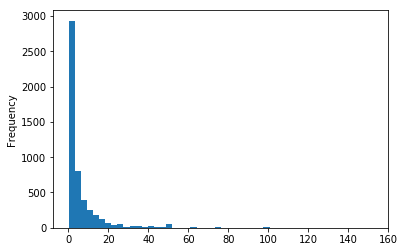

In [9]:
dataset[target].plot.hist(bins=50)
plt.show()

# Outlier tracking - VAMAT

In [10]:
toplimit = .95 #We drop the top 5%
botlimit = .02 #we drop the bottom 2%

In [11]:
#Surface cost calculation, quantile decomposition

#dataset['SURF_COST_CONVHULL'] = dataset['VAMAT'] / dataset['convex_hull_area']
dataset['SURF_COST_RECTANGLE'] = dataset['VAMAT'] / dataset['minimum_rectangle_area']
dataset['SURF_COST_MPATTERN'] = dataset['VAMAT'] / dataset['no_hole_area']
#dataset['SURF_COST_TOTAREA'] = dataset['VAMAT'] / dataset['total_area']

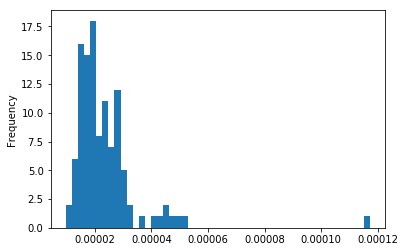

In [12]:
df = dataset[dataset['thickness'] == 2]
df['SURF_COST_MPATTERN'].plot.hist(bins=50)
plt.show()

In [13]:
#quantile decomposition
df=dataset[['thickness', 'SURF_COST_MPATTERN']].groupby('thickness').quantile([botlimit,toplimit])
df

SURF_COST_MPATTERN
thickness                         
2.0       0.02            0.000013
          0.95            0.000045
3.0       0.02            0.000018
          0.95            0.000060
4.0       0.02            0.000023
          0.95            0.000089
5.0       0.02            0.000028
          0.95            0.000091
6.0       0.02            0.000033
          0.95            0.000134
8.0       0.02            0.000044
          0.95            0.000182
10.0      0.02            0.000063
          0.95            0.000248
12.0      0.02            0.000059
          0.95            0.000247
15.0      0.02            0.000085
          0.95            0.000271

In [14]:
# If vamat is target, cleaning
if target == 'VAMAT' or target == 'VALTOT' or completecleaning:
    for (thickness, limit), value in df.iterrows():
        tresh = value.values[0]
        if limit == botlimit:
            mask = np.logical_and(dataset['thickness'] == thickness, dataset[df.columns.values[0]] < tresh)
            dataset = dataset[np.logical_not(mask)]
        elif limit == toplimit:
            mask = np.logical_and(dataset['thickness'] == thickness, dataset[df.columns.values[0]] > tresh)
            dataset = dataset[np.logical_not(mask)]
        #print((thickness, limit), tresh)

dataset.shape

(4704, 667)

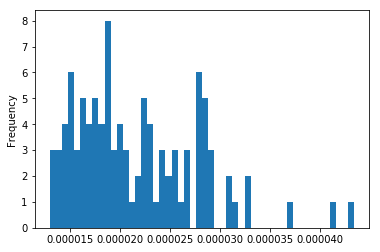

In [15]:
df = dataset[dataset['thickness'] == 2]
df['SURF_COST_MPATTERN'].plot.hist(bins=50)
plt.show()

In [16]:
skew(dataset[target])

4.243692352335607

/Users/cricket/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


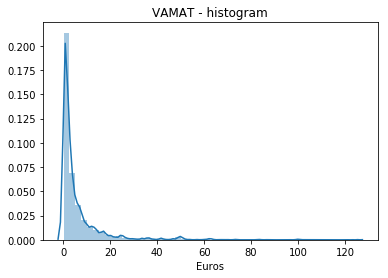

In [17]:
sns.distplot(dataset[target],)
plt.title(f'{target} - histogram')
plt.xlabel('Euros')
plt.show()

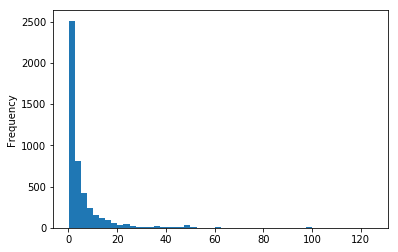

In [18]:
dataset[target].plot.hist(bins=50)
plt.show()

# Outlier tracking - VALAJOUT

In [19]:
toplimit = .95 #We drop the top 5%
botlimit = .02 #we drop the bottom 2%

In [20]:
#Cost per bend calculation

dataset['APPROX_BEND_COST'] = dataset['VALAJOUT'] / (dataset['bend_count']+1)

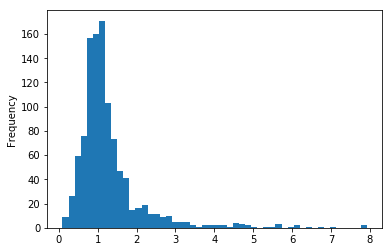

In [21]:
df = dataset[dataset['thickness'] == 6]
df['APPROX_BEND_COST'].plot.hist(bins=50)
plt.show()

In [22]:
#quantile decomposition
df=dataset[['thickness', 'APPROX_BEND_COST', 'bend_count']].groupby(['thickness', 'bend_count']).quantile([botlimit,toplimit])
df

APPROX_BEND_COST
thickness bend_count                       
2.0       0          0.02          0.704800
                     0.95          7.743000
          1          0.02          0.515800
                     0.95          2.330000
          2          0.02          0.245067
                     0.95          2.154667
          3          0.02          0.623350
                     0.95          1.954250
          4          0.02          0.573280
                     0.95          2.137800
          5          0.02          0.224867
                     0.95          2.048667
          6          0.02          0.703314
                     0.95          1.496000
          7          0.02          0.700500
                     0.95          1.551500
          8          0.02          0.782978
                     0.95          2.421111
          9          0.02          0.639000
                     0.95          0.639000
          14         0.02          0.502000
                     0.95          0.502000
3.0       0          0.02          0.218000
                     0.95          5.710000
          1          0.02          0.393500
                     0.95          1.483750
          2          0.02          0.405467
                     0.95          1.916500
          3          0.02          0.363850
                     0.95          2.401375
...                                     ...
10.0      0          0.02          0.592000
                     0.95          9.260000
          1          0.02          0.968600
                     0.95          4.102000
          2          0.02          0.489067
                     0.95          3.470000
          3          0.02          0.990350
                     0.95          3.877875
          4          0.02          1.137600
                     0.95          3.032000
          5          0.02          1.855000
                     0.95          1.855000
12.0      0          0.02          0.570000
                     0.95          6.860500
          1          0.02          0.165000
                     0.95          2.267500
          2          0.02          0.716667
                     0.95          1.723333
          3          0.02          0.615000
                     0.95          1.041000
          4          0.02          0.848240
                     0.95          1.819400
15.0      0          0.02          0.737000
                     0.95          8.658000
          1          0.02          1.100000
                     0.95          2.962250
          2          0.02          0.853333
                     0.95          1.526667
          3          0.02          0.870000
                     0.95          1.151250

[148 rows x 1 columns]

In [23]:
# If VALAJOUT is target, cleaning
if target == 'VALAJOUT' or target == 'VALTOT' or completecleaning:
    for (thickness, bend_count, limit), value in df.iterrows():
        tresh = value.values[0]
        mask1 = np.logical_and(dataset['thickness'] == thickness, dataset['bend_count'] == bend_count)
        if limit == botlimit:
            mask = np.logical_and(mask1, dataset[df.columns.values[0]] < tresh)
            dataset = dataset[np.logical_not(mask)]
        elif limit == toplimit:
            mask = np.logical_and(mask1, dataset[df.columns.values[0]] > tresh)
            dataset = dataset[np.logical_not(mask)]
        #print((thickness, limit), tresh)

dataset.shape

(4704, 668)

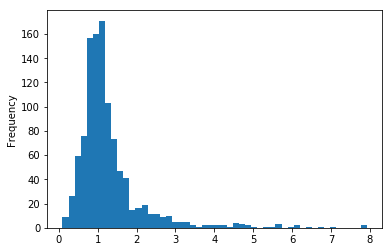

In [24]:
df = dataset[dataset['thickness'] == 6]
df['APPROX_BEND_COST'].plot.hist(bins=50)
plt.show()

## Target review

In [25]:
#Dataset definition
X = dataset
y = dataset[['VAMAT', 'VALAJOUT', 'VALTOT']]

,VAMAT
count,4704.000000
mean,5.897545
std,10.382502
min,0.110000
25%,0.810000
50%,2.270000
75%,6.260000
max,125.100000


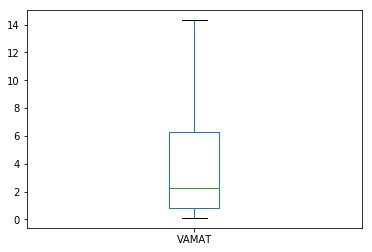

In [26]:
y[[target]].plot.box(sym='')
y[[target]].describe()

# Dataset re-ordering and Splitting

In [27]:
limitedset = ['cut_length', 'num_closed_patterns', 'num_open_patterns', 'total_area', 'minimum_rectangle_area',
              'minimum_rectangle_dim1', 'minimum_rectangle_dim2', 'convex_hull_area', 'no_hole_area', 'weight']

# 1 Bend as a float
limitedset.append('thickness')

# 2 Thickness as categories
#limitedset.extend([x for x in dataset.columns.values if x.startswith('thick_')])

# 3 Different counts
limitedset.extend(['radius_count', 'direction_count', 'bend_count'])

# 4 Bends in groups
#limitedset.extend([x for x in dataset.columns.values if x.startswith('bend_gr_')])

# 5 bends according DXF
#limitedset.extend([x for x in dataset.columns.values if x.startswith('benddxf_')])

# 6 according DXF, sorted by length
if target != 'VAMAT':
    limitedset.extend([x for x in dataset.columns.values if x.startswith('bendlength_')])


print(len(limitedset))
limitedset

14


['cut_length',
 'num_closed_patterns',
 'num_open_patterns',
 'total_area',
 'minimum_rectangle_area',
 'minimum_rectangle_dim1',
 'minimum_rectangle_dim2',
 'convex_hull_area',
 'no_hole_area',
 'weight',
 'thickness',
 'radius_count',
 'direction_count',
 'bend_count']

In [28]:
# Dataset splitting
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0 ,stratify=dataset['bend_group'])

print(X_train.shape, X_test.shape)

#ONLY FOR DATASET CLEANING PURPOSE
#X_test, X_train, y_test, y_train = train_test_split(X, y, test_size=0.5, random_state=0 ,stratify=dataset['bend_group'])

(3292, 668) (1412, 668)


# Box_cox feature creation

In [29]:
from scipy import stats
from scipy.special import inv_boxcox
_, lmbda = stats.boxcox(y_train[target], lmbda=None)
y_train['logtarget'] = y_train[target].apply(lambda x: stats.boxcox(x, lmbda))
y_test['logtarget'] = y_test[target].apply(lambda x: stats.boxcox(x, lmbda))

/Users/cricket/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/cricket/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


# Blocs creation

In [30]:
#Scaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [31]:
# Metric MSE
from sklearn.metrics import mean_squared_error

In [32]:
# Metric MAE
from sklearn.metrics import mean_absolute_error

In [33]:
# Metric MAPE Mean absolute percentage error
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

from sklearn.metrics import make_scorer
mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)
mape_scorer

make_scorer(mean_absolute_percentage_error, greater_is_better=False)

In [34]:
#regressions
import lightgbm as lgb

gbm = lgb.LGBMRegressor(objective='regression',
                        n_estimators=200,
                        random_state=0,
                       )

In [35]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [36]:
#Pipe definition
pipe = [('scaler', scaler), ('gbm', gbm)]

# Direct prediction

In [37]:
regpip = Pipeline(pipe)

In [38]:
regpip.fit(X_train[limitedset], y_train[target])

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('gbm', LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       learning_rate=0.1, max_depth=-1, min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=200,
       n_jobs=-1, num_leaves=31, objective='regression', random_state=0,
       reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=1))])

In [39]:
param_grid = {
    'gbm__num_leaves':[20, 30, 40],
    #'gbm__min_child_weight':np.logspace(-3,1,5),
    'gbm__min_data_in_leaf':[20,30,10],
    
    }

#MSE version
gridgbm = GridSearchCV(regpip, param_grid, cv=3, n_jobs=-2, scoring='neg_mean_squared_error', verbose=5)

#gridgbm = GridSearchCV(regpip, param_grid, cv=3, n_jobs=-2, scoring={'mse':'neg_mean_squared_error', 'mape':mape_scorer}, verbose=5, refit='mse')


#MAPE version
#gridgbm = GridSearchCV(regpip, param_grid, cv=3, n_jobs=-2, scoring=mape_scorer, verbose=2)

In [40]:
gridgbm.fit(X_train[limitedset], y_train[target])

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] gbm__min_data_in_leaf=20, gbm__num_leaves=20 ....................
[CV] gbm__min_data_in_leaf=20, gbm__num_leaves=20 ....................
[CV] gbm__min_data_in_leaf=20, gbm__num_leaves=20 ....................
[CV]  gbm__min_data_in_leaf=20, gbm__num_leaves=20, score=-5.52205458548529, total=   1.1s
[CV] gbm__min_data_in_leaf=20, gbm__num_leaves=30 ....................
[CV]  gbm__min_data_in_leaf=20, gbm__num_leaves=20, score=-4.308640227808652, total=   1.5s
[CV] gbm__min_data_in_leaf=20, gbm__num_leaves=30 ....................
[CV]  gbm__min_data_in_leaf=20, gbm__num_leaves=20, score=-9.16720098672876, total=   1.5s
[CV] gbm__min_data_in_leaf=20, gbm__num_leaves=30 ....................
[CV]  gbm__min_data_in_leaf=20, gbm__num_leaves=30, score=-4.266935057978245, total=   1.9s
[CV] gbm__min_data_in_leaf=20, gbm__num_leaves=40 ....................
[CV]  gbm__min_data_in_leaf=20, gbm__num_leaves=30, score=-8.923754228703551,

[Parallel(n_jobs=-2)]: Done  12 tasks      | elapsed:    7.5s


[CV]  gbm__min_data_in_leaf=30, gbm__num_leaves=30, score=-7.436202014862084, total=   2.0s
[CV] gbm__min_data_in_leaf=30, gbm__num_leaves=40 ....................
[CV]  gbm__min_data_in_leaf=30, gbm__num_leaves=30, score=-9.109703687217772, total=   1.7s
[CV] gbm__min_data_in_leaf=30, gbm__num_leaves=40 ....................
[CV]  gbm__min_data_in_leaf=30, gbm__num_leaves=30, score=-5.477686642709532, total=   2.2s
[CV] gbm__min_data_in_leaf=30, gbm__num_leaves=40 ....................
[CV]  gbm__min_data_in_leaf=30, gbm__num_leaves=40, score=-5.406911376963998, total=   2.2s
[CV] gbm__min_data_in_leaf=10, gbm__num_leaves=20 ....................
[CV]  gbm__min_data_in_leaf=30, gbm__num_leaves=40, score=-9.082913753564366, total=   2.4s
[CV] gbm__min_data_in_leaf=10, gbm__num_leaves=20 ....................
[CV]  gbm__min_data_in_leaf=30, gbm__num_leaves=40, score=-7.443595292338227, total=   2.9s
[CV] gbm__min_data_in_leaf=10, gbm__num_leaves=20 ....................
[CV]  gbm__min_data_in

[Parallel(n_jobs=-2)]: Done  27 out of  27 | elapsed:   17.6s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('gbm', LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       learning_rate=0.1, max_depth=-1, min_child_samples=20,
       min_child_weight=0.001, min_spli...0, reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=1))]),
       fit_params=None, iid=True, n_jobs=-2,
       param_grid={'gbm__num_leaves': [20, 30, 40], 'gbm__min_data_in_leaf': [20, 30, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=5)

In [41]:
print('target        :', target)
print('best score    :', gridgbm.best_score_)
print('best params   :', gridgbm.best_params_)
mapetest=mean_absolute_percentage_error(y_test[target], gridgbm.predict(X_test[limitedset]))
print('MAPE test set :', mapetest)
msetest = mean_squared_error(y_test[target], gridgbm.predict(X_test[limitedset]))
print('MSE  test set :', msetest)
msetrain = mean_squared_error(y_train[target], gridgbm.predict(X_train[limitedset]))
print('MSE train set :', msetrain)


target        : VAMAT
best score    : -5.893678040948717
best params   : {'gbm__min_data_in_leaf': 10, 'gbm__num_leaves': 40}
MAPE test set : 10.248554085063503
MSE  test set : 4.62713413625453
MSE train set : 0.2186512132205344


## Hyperopt

In [42]:
from hyperopt import hp, tpe
from hyperopt.fmin import fmin
from sklearn.model_selection import cross_val_score

In [43]:
def objective(params):
    params = {
        'num_leaves': int(params['num_leaves']),
        'min_data_in_leaf': int(params['min_data_in_leaf']),
        'min_child_weight': params['min_child_weight'],
        #'n_estimators': int(params['n_estimators']),
        'colsample_bytree': params['colsample_bytree'],
        'bagging_fraction': params['bagging_fraction'],
        'bagging_freq': params['bagging_freq'],
        'reg_alpha': params['reg_alpha'],
        'reg_lambda': params['reg_lambda'],
        'max_depth':int(params['max_depth']),
        'learning_rate':params['learning_rate'],
        }
    
    clf = lgb.LGBMRegressor(objective='regression', n_estimators=200, **params)

    pipe = [('scaler', scaler), ('xgb', clf)]
    regpip = Pipeline(pipe)    
    
    score = cross_val_score(regpip, X_train[limitedset], y_train[target], scoring='neg_mean_squared_error', cv=3, n_jobs=-2).mean()
    print("MSE {:.3f} - params {}".format(score, params))
    return -score

space = {
    'num_leaves': hp.uniform('num_leaves', 5, 40),
    'min_data_in_leaf': hp.uniform('min_data_in_leaf',10, 40),
    'min_child_weight': hp.uniform('min_child_weight', 0.001, 20),
    #'n_estimators': hp.uniform('n_estimators', 100, 500),
    'colsample_bytree': hp.uniform('colsample_bytree', 0., 1.0),
    'bagging_fraction': hp.uniform('bagging_fraction', 0., 1.0),
    'bagging_freq': hp.randint('bagging_freq', 15),
    'reg_alpha': hp.loguniform('reg_alpha', -3, 3),
    'reg_lambda': hp.loguniform('reg_lambda', -3, 3),
    'max_depth': hp.uniform('max_depth', 3, 15),
    'learning_rate': hp.uniform('learning_rate', 0.001, .1),
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=50)

MSE -7.226 - params {'num_leaves': 5, 'min_data_in_leaf': 16, 'min_child_weight': 8.990599276704828, 'colsample_bytree': 0.5218000226433206, 'bagging_fraction': 0.8247922777929219, 'bagging_freq': 11, 'reg_alpha': 0.1929741126120143, 'reg_lambda': 3.465267256510757, 'max_depth': 3, 'learning_rate': 0.02870444075908818}
MSE -7.353 - params {'num_leaves': 38, 'min_data_in_leaf': 30, 'min_child_weight': 16.36506462322338, 'colsample_bytree': 0.34944917663667885, 'bagging_fraction': 0.6588849390712704, 'bagging_freq': 11, 'reg_alpha': 0.06888397617753804, 'reg_lambda': 0.5565972114070569, 'max_depth': 10, 'learning_rate': 0.08218148532001793}
MSE -46.640 - params {'num_leaves': 19, 'min_data_in_leaf': 12, 'min_child_weight': 1.2982195848938, 'colsample_bytree': 0.9284760330689213, 'bagging_fraction': 0.024098311829602426, 'bagging_freq': 5, 'reg_alpha': 0.23344495001536414, 'reg_lambda': 0.1932464197862072, 'max_depth': 12, 'learning_rate': 0.010437329601225013}
MSE -12.463 - params {'num_

MSE -6.005 - params {'num_leaves': 35, 'min_data_in_leaf': 16, 'min_child_weight': 11.399504549727375, 'colsample_bytree': 0.4490172632299135, 'bagging_fraction': 0.7422138862561183, 'bagging_freq': 8, 'reg_alpha': 0.9080854445742045, 'reg_lambda': 1.5610084391222412, 'max_depth': 5, 'learning_rate': 0.06018265803531191}
MSE -8.241 - params {'num_leaves': 35, 'min_data_in_leaf': 39, 'min_child_weight': 19.627675782500013, 'colsample_bytree': 0.6276071659944326, 'bagging_fraction': 0.7473206556845643, 'bagging_freq': 1, 'reg_alpha': 2.3923048696109195, 'reg_lambda': 2.149826510232627, 'max_depth': 3, 'learning_rate': 0.04027824085486411}
MSE -6.327 - params {'num_leaves': 28, 'min_data_in_leaf': 17, 'min_child_weight': 8.839260121560695, 'colsample_bytree': 0.48837039868577087, 'bagging_fraction': 0.6532714752311598, 'bagging_freq': 13, 'reg_alpha': 3.427009716564774, 'reg_lambda': 3.7382220480638595, 'max_depth': 4, 'learning_rate': 0.06984471786784212}
MSE -23.924 - params {'num_leave

In [44]:
params = {
        'num_leaves': int(best['num_leaves']),
        'min_data_in_leaf': int(best['min_data_in_leaf']),
        'min_child_weight': best['min_child_weight'],
        #'n_estimators': int(best['n_estimators']),
        'colsample_bytree': best['colsample_bytree'],
        'bagging_fraction': best['bagging_fraction'],
        'bagging_freq': best['bagging_freq'],
        'reg_alpha': best['reg_alpha'],
        'reg_lambda': best['reg_lambda'],
        'max_depth':int(best['max_depth']),
        'learning_rate':best['learning_rate'],
        }

clf = lgb.LGBMRegressor(objective='regression', n_estimators=200, **params)
pipe = [('scaler', scaler), ('gbm', clf)]
regpip = Pipeline(pipe)
regpip.fit(X_train[limitedset], y_train[target])

preds = regpip.predict(X_test[limitedset])

msetest = mean_squared_error(y_test[target], preds)
mapetest = mean_absolute_percentage_error(y_test[target], preds)
msetrain = mean_squared_error(y_train[target], regpip.predict(X_train[limitedset]))
print(target)
#print(clf.get_params())
print(params)
print('MAPE test:', mapetest)
print('MSE  test:', msetest)
print('MSE train:', msetrain)


VAMAT
{'num_leaves': 35, 'min_data_in_leaf': 10, 'min_child_weight': 9.33189533919738, 'colsample_bytree': 0.6056639251906237, 'bagging_fraction': 0.7116821887064331, 'bagging_freq': 8, 'reg_alpha': 1.114793290516118, 'reg_lambda': 1.9900989306757577, 'max_depth': 5, 'learning_rate': 0.058327793181553234}
MAPE test: 14.734388178019842
MSE  test: 3.8846286667676497
MSE train: 1.6688441790563573


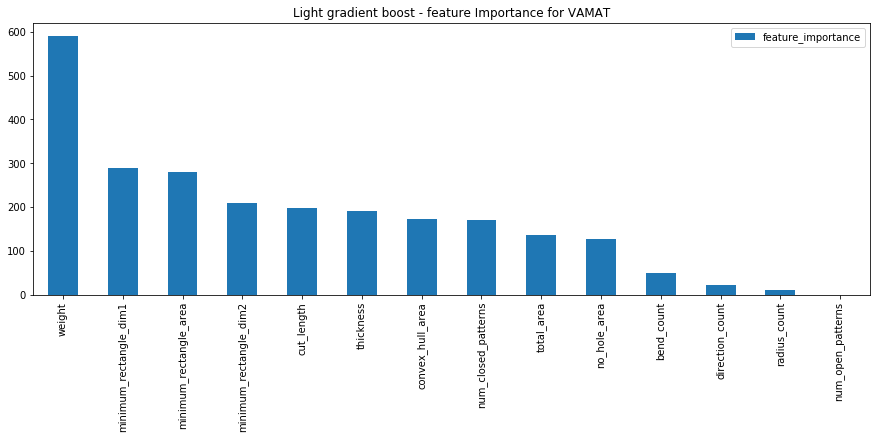

In [45]:
featimp = list(regpip.named_steps['gbm'].feature_importances_)
df = pd.DataFrame({'feature_importance':featimp}, index =limitedset)
df = df.sort_values('feature_importance', ascending=False)
df[:50].plot.bar(figsize=(15,5))
plt.title(f'Light gradient boost - feature Importance for {target}')
plt.show()

# BOX-COX prediction

In [46]:
gbmlog = lgb.LGBMRegressor(objective='regression',
                        n_estimators=200,
                        random_state=0,
                       )
pipe = [('scaler', scaler), ('gbm', gbmlog)]
regpiplog = Pipeline(pipe)

In [47]:
regpiplog.fit(X_train[limitedset], y_train['logtarget'])

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('gbm', LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       learning_rate=0.1, max_depth=-1, min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=200,
       n_jobs=-1, num_leaves=31, objective='regression', random_state=0,
       reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=1))])

In [48]:
param_grid = {
    'gbm__num_leaves':[20, 30, 40],
    'gbm__min_child_weight':np.logspace(-3,1,5),
    'gbm__min_data_in_leaf':[20,30,10],
    }

#MAE version
gridgbmlog = GridSearchCV(regpiplog, param_grid, cv=3, n_jobs=-2, scoring=bcmetric, verbose=5)

#MAPE version
#gridgbmlog = GridSearchCV(regpiplog, param_grid, cv=3, n_jobs=-2, scoring=mape_scorer, verbose=2)

In [49]:
%%time
gridgbmlog.fit(X_train[limitedset], y_train['logtarget'])

Fitting 3 folds for each of 45 candidates, totalling 135 fits
[CV] gbm__min_child_weight=0.001, gbm__min_data_in_leaf=20, gbm__num_leaves=20 
[CV] gbm__min_child_weight=0.001, gbm__min_data_in_leaf=20, gbm__num_leaves=20 
[CV] gbm__min_child_weight=0.001, gbm__min_data_in_leaf=20, gbm__num_leaves=20 
[CV]  gbm__min_child_weight=0.001, gbm__min_data_in_leaf=20, gbm__num_leaves=20, score=-0.02069468050278575, total=   1.2s
[CV]  gbm__min_child_weight=0.001, gbm__min_data_in_leaf=20, gbm__num_leaves=20, score=-0.02058363992274444, total=   1.2s
[CV] gbm__min_child_weight=0.001, gbm__min_data_in_leaf=20, gbm__num_leaves=30 
[CV] gbm__min_child_weight=0.001, gbm__min_data_in_leaf=20, gbm__num_leaves=30 
[CV]  gbm__min_child_weight=0.001, gbm__min_data_in_leaf=20, gbm__num_leaves=20, score=-0.02154823194066443, total=   1.5s
[CV] gbm__min_child_weight=0.001, gbm__min_data_in_leaf=20, gbm__num_leaves=30 
[CV]  gbm__min_child_weight=0.001, gbm__min_data_in_leaf=20, gbm__num_leaves=30, score=-0

[Parallel(n_jobs=-2)]: Done  12 tasks      | elapsed:    7.4s


[CV]  gbm__min_child_weight=0.001, gbm__min_data_in_leaf=30, gbm__num_leaves=30, score=-0.022166370916813075, total=   2.0s
[CV] gbm__min_child_weight=0.001, gbm__min_data_in_leaf=30, gbm__num_leaves=40 
[CV]  gbm__min_child_weight=0.001, gbm__min_data_in_leaf=30, gbm__num_leaves=30, score=-0.02103064693409091, total=   2.0s
[CV] gbm__min_child_weight=0.001, gbm__min_data_in_leaf=30, gbm__num_leaves=40 
[CV]  gbm__min_child_weight=0.001, gbm__min_data_in_leaf=30, gbm__num_leaves=30, score=-0.020537001287514137, total=   1.8s
[CV] gbm__min_child_weight=0.001, gbm__min_data_in_leaf=30, gbm__num_leaves=40 
[CV]  gbm__min_child_weight=0.001, gbm__min_data_in_leaf=30, gbm__num_leaves=40, score=-0.02151607276242283, total=   2.3s
[CV] gbm__min_child_weight=0.001, gbm__min_data_in_leaf=10, gbm__num_leaves=20 
[CV]  gbm__min_child_weight=0.001, gbm__min_data_in_leaf=30, gbm__num_leaves=40, score=-0.0228967099143481, total=   2.5s
[CV] gbm__min_child_weight=0.001, gbm__min_data_in_leaf=10, gbm_

[CV] gbm__min_child_weight=0.1, gbm__min_data_in_leaf=20, gbm__num_leaves=20 
[CV]  gbm__min_child_weight=0.01, gbm__min_data_in_leaf=10, gbm__num_leaves=40, score=-0.0216613425306065, total=   2.6s
[CV] gbm__min_child_weight=0.1, gbm__min_data_in_leaf=20, gbm__num_leaves=20 
[CV]  gbm__min_child_weight=0.1, gbm__min_data_in_leaf=20, gbm__num_leaves=20, score=-0.02069468050278575, total=   1.1s
[CV] gbm__min_child_weight=0.1, gbm__min_data_in_leaf=20, gbm__num_leaves=30 
[CV]  gbm__min_child_weight=0.1, gbm__min_data_in_leaf=20, gbm__num_leaves=20, score=-0.02154823194066443, total=   1.4s
[CV] gbm__min_child_weight=0.1, gbm__min_data_in_leaf=20, gbm__num_leaves=30 
[CV]  gbm__min_child_weight=0.1, gbm__min_data_in_leaf=20, gbm__num_leaves=20, score=-0.02058363992274444, total=   1.4s
[CV] gbm__min_child_weight=0.1, gbm__min_data_in_leaf=20, gbm__num_leaves=30 
[CV]  gbm__min_child_weight=0.1, gbm__min_data_in_leaf=20, gbm__num_leaves=30, score=-0.021855396790850152, total=   1.9s
[CV]

[Parallel(n_jobs=-2)]: Done  66 tasks      | elapsed:   41.7s


[CV]  gbm__min_child_weight=0.1, gbm__min_data_in_leaf=30, gbm__num_leaves=30, score=-0.022166370916813075, total=   1.8s
[CV] gbm__min_child_weight=0.1, gbm__min_data_in_leaf=30, gbm__num_leaves=40 
[CV]  gbm__min_child_weight=0.1, gbm__min_data_in_leaf=30, gbm__num_leaves=30, score=-0.02103064693409091, total=   1.8s
[CV] gbm__min_child_weight=0.1, gbm__min_data_in_leaf=30, gbm__num_leaves=40 
[CV]  gbm__min_child_weight=0.1, gbm__min_data_in_leaf=30, gbm__num_leaves=30, score=-0.020537001287514137, total=   2.0s
[CV] gbm__min_child_weight=0.1, gbm__min_data_in_leaf=30, gbm__num_leaves=40 
[CV]  gbm__min_child_weight=0.1, gbm__min_data_in_leaf=30, gbm__num_leaves=40, score=-0.0228967099143481, total=   2.6s
[CV] gbm__min_child_weight=0.1, gbm__min_data_in_leaf=10, gbm__num_leaves=20 
[CV]  gbm__min_child_weight=0.1, gbm__min_data_in_leaf=30, gbm__num_leaves=40, score=-0.020586757009536178, total=   2.0s
[CV] gbm__min_child_weight=0.1, gbm__min_data_in_leaf=10, gbm__num_leaves=20 
[CV

[CV] gbm__min_child_weight=10.0, gbm__min_data_in_leaf=20, gbm__num_leaves=20 
[CV]  gbm__min_child_weight=10.0, gbm__min_data_in_leaf=20, gbm__num_leaves=20, score=-0.02069468050278575, total=   1.2s
[CV] gbm__min_child_weight=10.0, gbm__min_data_in_leaf=20, gbm__num_leaves=30 
[CV]  gbm__min_child_weight=10.0, gbm__min_data_in_leaf=20, gbm__num_leaves=20, score=-0.02154823194066443, total=   1.4s
[CV] gbm__min_child_weight=10.0, gbm__min_data_in_leaf=20, gbm__num_leaves=30 
[CV]  gbm__min_child_weight=10.0, gbm__min_data_in_leaf=20, gbm__num_leaves=20, score=-0.02058363992274444, total=   1.3s
[CV] gbm__min_child_weight=10.0, gbm__min_data_in_leaf=20, gbm__num_leaves=30 
[CV]  gbm__min_child_weight=10.0, gbm__min_data_in_leaf=20, gbm__num_leaves=30, score=-0.02162830117673636, total=   1.7s
[CV] gbm__min_child_weight=10.0, gbm__min_data_in_leaf=20, gbm__num_leaves=40 
[CV]  gbm__min_child_weight=10.0, gbm__min_data_in_leaf=20, gbm__num_leaves=30, score=-0.021855396790850152, total=  

[Parallel(n_jobs=-2)]: Done 135 out of 135 | elapsed:  1.4min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('gbm', LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       learning_rate=0.1, max_depth=-1, min_child_samples=20,
       min_child_weight=0.001, min_spli...0, reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=1))]),
       fit_params=None, iid=True, n_jobs=-2,
       param_grid={'gbm__num_leaves': [20, 30, 40], 'gbm__min_child_weight': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01]), 'gbm__min_data_in_leaf': [20, 30, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=5)

In [50]:
print('target        :', target)
print('best score    :', gridgbmlog.best_score_)
print('best params   :', gridgbmlog.best_params_)
mapetest=mean_absolute_percentage_error(y_test[target], inv_boxcox(gridgbmlog.predict(X_test[limitedset]), lmbda))
print('MAPE test set :', mapetest)
msetest = mean_squared_error(y_test[target], inv_boxcox(gridgbmlog.predict(X_test[limitedset]), lmbda))
print('MSE  test set :', msetest)
msetrain = mean_squared_error(y_train[target], inv_boxcox(gridgbmlog.predict(X_train[limitedset]), lmbda))
print('MSE train set :', msetrain)

target        : VAMAT
best score    : -0.020806811921363938
best params   : {'gbm__min_child_weight': 0.001, 'gbm__min_data_in_leaf': 10, 'gbm__num_leaves': 30}
MAPE test set : 9.229062402951046
MSE  test set : 3.8622590806604324
MSE train set : 0.6735462198054308


In [51]:
def objective(params):
    params = {
        'num_leaves': int(params['num_leaves']),
        'min_data_in_leaf': int(params['min_data_in_leaf']),
        'min_child_weight': params['min_child_weight'],
        #'n_estimators': int(params['n_estimators']),
        'colsample_bytree': params['colsample_bytree'],
        'bagging_fraction': params['bagging_fraction'],
        'bagging_freq': params['bagging_freq'],
        'reg_alpha': params['reg_alpha'],
        'reg_lambda': params['reg_lambda'],
        'max_depth':int(params['max_depth']),
        'learning_rate':params['learning_rate'],
        }
    
    clf = lgb.LGBMRegressor(objective='regression', n_estimators=200, **params)

    pipe = [('scaler', scaler), ('gbm', clf)]
    regpip = Pipeline(pipe)    
    
    score = cross_val_score(regpip, X_train[limitedset], y_train['logtarget'], scoring=bcmetric, cv=3, n_jobs=-2).mean()
    print("MSE {:.3f} - params {}".format(score, params))
    return -score

space = {
    'num_leaves': hp.uniform('num_leaves', 5, 40),
    'min_data_in_leaf': hp.uniform('min_data_in_leaf', 5, 20),
    'min_child_weight': hp.uniform('min_child_weight', 0.001, 20),
    #'n_estimators': hp.uniform('n_estimators', 100, 500),
    'colsample_bytree': hp.uniform('colsample_bytree', 0., 1.0),
    'bagging_fraction': hp.uniform('bagging_fraction', 0., 1.0),
    'bagging_freq': hp.randint('bagging_freq', 15),
    'reg_alpha': hp.loguniform('reg_alpha', -3, 3),
    'reg_lambda': hp.loguniform('reg_lambda', -3, 3),
    'max_depth': hp.uniform('max_depth', 3, 15),
    'learning_rate': hp.uniform('learning_rate', 0.001, .1),
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=50)

MSE -0.041 - params {'num_leaves': 24, 'min_data_in_leaf': 14, 'min_child_weight': 2.3623727000491526, 'colsample_bytree': 0.9923637463786933, 'bagging_fraction': 0.06087074415543314, 'bagging_freq': 13, 'reg_alpha': 0.5311409809356246, 'reg_lambda': 0.533068624983554, 'max_depth': 12, 'learning_rate': 0.07972831507972866}
MSE -0.028 - params {'num_leaves': 26, 'min_data_in_leaf': 7, 'min_child_weight': 7.759917581124546, 'colsample_bytree': 0.26150562845504866, 'bagging_fraction': 0.7708293592476366, 'bagging_freq': 8, 'reg_alpha': 1.5779267643158286, 'reg_lambda': 0.15962934989615726, 'max_depth': 10, 'learning_rate': 0.09776683812770552}
MSE -0.023 - params {'num_leaves': 31, 'min_data_in_leaf': 6, 'min_child_weight': 3.2597115647017394, 'colsample_bytree': 0.7797138575063519, 'bagging_fraction': 0.2403506314122722, 'bagging_freq': 2, 'reg_alpha': 0.5689861120873951, 'reg_lambda': 16.631249747893666, 'max_depth': 8, 'learning_rate': 0.0451418393606386}
MSE -0.071 - params {'num_leav

MSE -0.022 - params {'num_leaves': 12, 'min_data_in_leaf': 12, 'min_child_weight': 16.546416654881096, 'colsample_bytree': 0.6579729836203542, 'bagging_fraction': 0.8991119963248444, 'bagging_freq': 1, 'reg_alpha': 0.053777444713694465, 'reg_lambda': 2.9639538267957897, 'max_depth': 3, 'learning_rate': 0.042110667140425634}
MSE -0.023 - params {'num_leaves': 16, 'min_data_in_leaf': 16, 'min_child_weight': 7.412786451479697, 'colsample_bytree': 0.4715565671987406, 'bagging_fraction': 0.6203873051194333, 'bagging_freq': 1, 'reg_alpha': 0.0796267046551227, 'reg_lambda': 11.60585113439069, 'max_depth': 3, 'learning_rate': 0.08172636353487449}
MSE -0.022 - params {'num_leaves': 5, 'min_data_in_leaf': 13, 'min_child_weight': 4.175281161190311, 'colsample_bytree': 0.950600258160547, 'bagging_fraction': 0.9802736762207902, 'bagging_freq': 13, 'reg_alpha': 0.10144689967714925, 'reg_lambda': 0.3351274125497203, 'max_depth': 7, 'learning_rate': 0.05404118498811408}
MSE -0.021 - params {'num_leave

In [52]:
%%time
params = {
        'num_leaves': int(best['num_leaves']),
        'min_data_in_leaf': int(best['min_data_in_leaf']),
        'min_child_weight': best['min_child_weight'],
        #'n_estimators': int(best['n_estimators']),
        'colsample_bytree': best['colsample_bytree'],
        'bagging_fraction': best['bagging_fraction'],
        'bagging_freq': best['bagging_freq'],
        'reg_alpha': best['reg_alpha'],
        'reg_lambda': best['reg_lambda'],
        'max_depth':int(best['max_depth']),
        'learning_rate':best['learning_rate'],
        }

clflog = lgb.LGBMRegressor(objective='regression', n_estimators=200, **params)
pipe = [('scaler', scaler), ('gbm', clflog)]
regpiplog = Pipeline(pipe)
regpiplog.fit(X_train[limitedset], y_train['logtarget'])

preds = inv_boxcox(regpiplog.predict(X_test[limitedset]), lmbda)

msetest = mean_squared_error(y_test[target], preds)
mapetest = mean_absolute_percentage_error(y_test[target], preds)
msetrain = mean_squared_error(y_train[target], inv_boxcox(regpiplog.predict(X_train[limitedset]), lmbda))
print(target)
#print(clf.get_params())
print(params)
print('MAPE test:', mapetest)
print('MSE  test:', msetest)
print('MSE train:', msetrain)

VAMAT
{'num_leaves': 15, 'min_data_in_leaf': 18, 'min_child_weight': 7.685747825183742, 'colsample_bytree': 0.707628512186999, 'bagging_fraction': 0.5813206882949856, 'bagging_freq': 1, 'reg_alpha': 0.10967664437124054, 'reg_lambda': 10.832803840460594, 'max_depth': 5, 'learning_rate': 0.07898886880813479}
MAPE test: 9.926954450838531
MSE  test: 5.830687745113058
MSE train: 3.6780377114814837
CPU times: user 425 ms, sys: 17.3 ms, total: 442 ms
Wall time: 129 ms


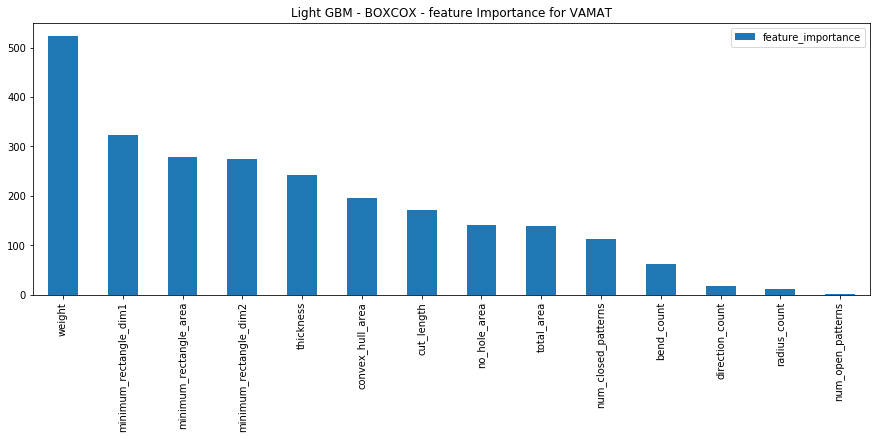

In [53]:
featimp = list(regpiplog.named_steps['gbm'].feature_importances_)
df = pd.DataFrame({'feature_importance':featimp}, index =limitedset)
df = df.sort_values('feature_importance', ascending=False)
df[:50].plot.bar(figsize=(15,5))
plt.title(f'Light GBM - BOXCOX - feature Importance for {target}')
plt.show()

# Solution comparison

In [54]:
prediction_lgbm = gridgbm.predict(X_test[limitedset])
prediction_lgbm_log = inv_boxcox(gridgbmlog.predict(X_test[limitedset]), lmbda)

In [55]:
resultset = pd.DataFrame({f'target': y_test[target],
                          'pred_lgbm':prediction_lgbm,
                          'pred_lgbm_BOXCOX':prediction_lgbm_log,
                            }, index=y_test.index)
resultset.head()

,pred_lgbm,pred_lgbm_BOXCOX,target
COART,,,
L3041770,3.743200,3.850384,3.40
L6802530,0.165920,0.156556,0.15
L2605410,11.238671,10.765516,11.21
L7058820,8.934647,9.043264,6.70
L6011841,22.495153,21.709876,21.00


In [56]:
#Solution saving
resultset.to_csv(f'{target}_pred_lgbm.csv')


In [57]:
#MAPE
mape = mean_absolute_percentage_error(resultset['target'], resultset['pred_lgbm'])
mapelog = mean_absolute_percentage_error(resultset['target'], resultset['pred_lgbm_BOXCOX'])
print('mape', mape)
print('mapelog', mapelog)

mape 10.248554085063503
mapelog 9.229062402951046


In [58]:
#MSE
mse = mean_squared_error(resultset['target'], resultset['pred_lgbm'])
mselog = mean_squared_error(resultset['target'], resultset['pred_lgbm_BOXCOX'])
print('mse', mse)
print('mselog', mselog)

mse 4.62713413625453
mselog 3.8622590806604324


In [59]:
resultset['MSE_lgbm'] = (resultset['target']-resultset['pred_lgbm'])**2
resultset['MSE_log_lgbm'] = (resultset['target']-resultset['pred_lgbm_BOXCOX'])**2
resultset.head()

,pred_lgbm,pred_lgbm_BOXCOX,target,MSE_lgbm,MSE_log_lgbm
COART,,,,,
L3041770,3.743200,3.850384,3.40,0.117786,0.202846
L6802530,0.165920,0.156556,0.15,0.000253,0.000043
L2605410,11.238671,10.765516,11.21,0.000822,0.197566
L7058820,8.934647,9.043264,6.70,4.993646,5.490887
L6011841,22.495153,21.709876,21.00,2.235482,0.503923


In [60]:
resultset['MSE_lgbm'].mean()

4.627134136254531

In [61]:
#Data assembly
comparisonset = pd.merge(resultset.reset_index(), X_test.reset_index(), on='COART', how='inner')
comparisonset.head()

,COART,pred_lgbm,pred_lgbm_BOXCOX,target,MSE_lgbm,MSE_log_lgbm,cut_length,num_closed_patterns,num_open_patterns,total_area,...,VAMAT,VALAJOUT,VALTOT,VOL_COST_CONVHULL,VOL_COST_RECTANGLE,VOL_COST_MPATTERN,bend_group,SURF_COST_RECTANGLE,SURF_COST_MPATTERN,APPROX_BEND_COST
0,L3041770,3.743200,3.850384,3.40,0.117786,0.202846,1836.297974,1,0,41957.070312,...,3.40,6.38,9.78,0.000009,0.000008,0.000010,3-5,0.000063,0.000081,1.063333
1,L6802530,0.165920,0.156556,0.15,0.000253,0.000043,374.891052,4,0,2171.109131,...,0.15,3.37,3.52,0.000009,0.000007,0.000010,1-2,0.000043,0.000060,1.123333
2,L2605410,11.238671,10.765516,11.21,0.000822,0.197566,3051.648682,16,0,140381.875000,...,11.21,5.43,16.64,0.000009,0.000008,0.000010,1-2,0.000066,0.000079,2.715000
3,L7058820,8.934647,9.043264,6.70,4.993646,5.490887,1793.807251,3,0,65955.062500,...,6.70,2.12,8.82,0.000007,0.000006,0.000007,0,0.000072,0.000086,2.120000
4,L6011841,22.495153,21.709876,21.00,2.235482,0.503923,2885.971436,9,0,263535.531250,...,21.00,5.38,26.38,0.000012,0.000008,0.000013,1-2,0.000050,0.000079,1.793333


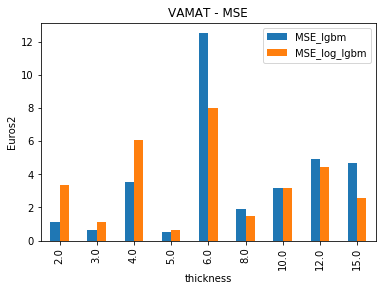

,MSE_lgbm,MSE_log_lgbm,COART
,mean,mean,count
thickness,,,
2.0,1.146016,3.368378,37
3.0,0.618419,1.141120,132
4.0,3.518359,6.073254,168
5.0,0.534447,0.631838,163
6.0,12.528677,7.996751,316
8.0,1.885341,1.480717,275
10.0,3.155362,3.208916,178
12.0,4.905919,4.452104,96


In [62]:
# Is the error sourced by thickness ?
df = comparisonset[['MSE_lgbm', 'MSE_log_lgbm', 'thickness']].groupby('thickness').mean()
df.plot.bar()
plt.title(f'{target} - MSE')
plt.ylabel('Euros2')
plt.show()
comparisonset.groupby('thickness').agg({'MSE_lgbm':['mean'],
                                         'MSE_log_lgbm':['mean'],
                                         'COART':['count']})

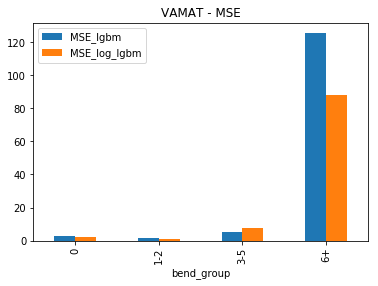

,MSE_lgbm,MSE_log_lgbm,COART
,mean,mean,count
bend_group,,,
0,2.669676,2.131176,578
1-2,1.474978,1.085186,625
3-5,5.064711,7.313603,184
6+,125.466893,87.909844,25


In [63]:
# Is the error sourced by number of bends ?

df = comparisonset[['MSE_lgbm', 'MSE_log_lgbm', 'bend_group']].groupby('bend_group').mean()
df.plot.bar()
plt.title(f'{target} - MSE')
plt.show()
comparisonset.groupby('bend_group').agg({'MSE_lgbm':['mean'],
                                         'MSE_log_lgbm':['mean'],
                                         'COART':['count']})

In [64]:
comparisonset['MAPE_error'] = comparisonset.apply(lambda x: mean_absolute_percentage_error(x['target'], x['pred_lgbm']), axis=1)
comparisonset['MAPE_log_error'] = comparisonset.apply(lambda x: mean_absolute_percentage_error(x['target'], x['pred_lgbm_BOXCOX']), axis=1)

comparisonset[['target', 'pred_lgbm', 'MAPE_error', 'pred_lgbm_BOXCOX', 'MAPE_log_error']].head()

,target,pred_lgbm,MAPE_error,pred_lgbm_BOXCOX,MAPE_log_error
0,3.40,3.743200,10.094116,3.850384,13.246586
1,0.15,0.165920,10.613316,0.156556,4.370717
2,11.21,11.238671,0.255760,10.765516,3.965066
3,6.70,8.934647,33.352936,9.043264,34.974091
4,21.00,22.495153,7.119775,21.709876,3.380360


In [65]:
#MAPE
comparisonset['MAPE_error'].mean()

10.248554085063493

In [66]:
#If bends use this line
if target == 'VALAJOUT' or target == 'VALTOT':
    df = comparisonset[['MSE_lgbm', 'MSE_log_lgbm','MAPE_error', 'MAPE_log_error', 'thickness', 'bend_group', 'COART']].groupby(['thickness', 'bend_group'])

#If no bends use this line
if target == 'VAMAT':
    df = comparisonset[['MSE_lgbm', 'MSE_log_lgbm','MAPE_error', 'MAPE_log_error', 'thickness', 'COART']].groupby(['thickness'])

perf = df.agg({'MSE_lgbm': ['mean', 'max'],
        'MSE_log_lgbm': ['mean', 'max'],
        'MAPE_error': ['mean', 'max'],
        'MAPE_log_error': ['mean', 'max'],
        'COART':['count'] })
perf

MSE_lgbm              MSE_log_lgbm              MAPE_error  \
                mean          max         mean          max       mean   
thickness                                                                
2.0         1.146016     8.792687     3.368378    47.894868  11.631715   
3.0         0.618419    24.124388     1.141120    63.153059   7.830935   
4.0         3.518359   350.443053     6.073254   568.421450   8.816713   
5.0         0.534447    21.909699     0.631838    82.567748   8.616612   
6.0        12.528677  3093.730383     7.996751  2091.521393  10.132910   
8.0         1.885341   163.128158     1.480717    56.160507   9.970275   
10.0        3.155362   130.365038     3.208916   140.529042   9.824124   
12.0        4.905919   226.329650     4.452104   130.840735  15.882659   
15.0        4.704824    50.762216     2.599923    28.385068  19.232583   

                      MAPE_log_error             COART  
                  max           mean         max count  
thickness                                               
2.0         75.641481       8.836967   44.955146    37  
3.0         48.483189       6.924469   48.416651   132  
4.0         50.545271       8.173979   54.583552   168  
5.0         45.607399       7.460745   44.231728   163  
6.0        120.002831       8.704674   98.669157   316  
8.0        140.567221       9.115351  149.880628   275  
10.0       117.776798       9.121870  115.189190   178  
12.0        83.654197      15.424623   72.980946    96  
15.0        77.339633      17.856451   72.150073    47

In [67]:
perf.loc[2.]['MSE_lgbm', 'mean']


1.1460160702086382

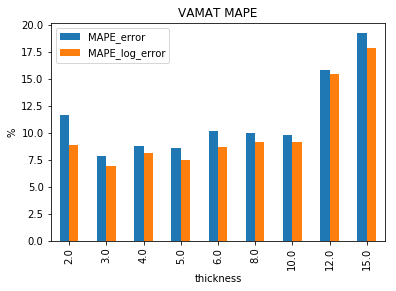

,MAPE_error,MAPE_log_error,COART
,mean,mean,count
thickness,,,
2.0,11.631715,8.836967,37
3.0,7.830935,6.924469,132
4.0,8.816713,8.173979,168
5.0,8.616612,7.460745,163
6.0,10.132910,8.704674,316
8.0,9.970275,9.115351,275
10.0,9.824124,9.121870,178
12.0,15.882659,15.424623,96


In [68]:
df = comparisonset[['MAPE_error', 'MAPE_log_error', 'thickness']].groupby('thickness').mean()
df.plot.bar()
plt.title(f'{target} MAPE')
plt.ylabel('%')
plt.show()
comparisonset.groupby('thickness').agg({'MAPE_error':['mean'],
                                         'MAPE_log_error':['mean'],
                                         'COART':['count']})

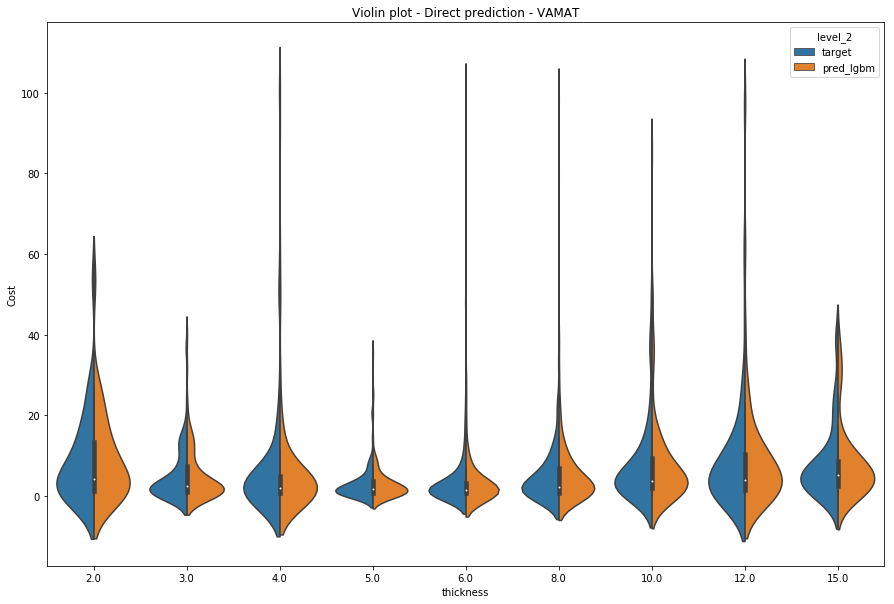

In [69]:
#Violin plot
df=comparisonset[['target', 'pred_lgbm', 'COART', 'thickness']]
#df=df[df['thickness']!=15]
df.set_index(['COART', 'thickness'], inplace=True)
df = df.stack().reset_index()
fig, ax = plt.subplots(figsize=(15,10))
#ax.set_ylim(-100, 100)
sns.violinplot(x="thickness", y=0, data=df, split=True, hue='level_2', ax=ax)
plt.title(f'Violin plot - Direct prediction - {target}')
plt.ylabel('Cost')
plt.show()

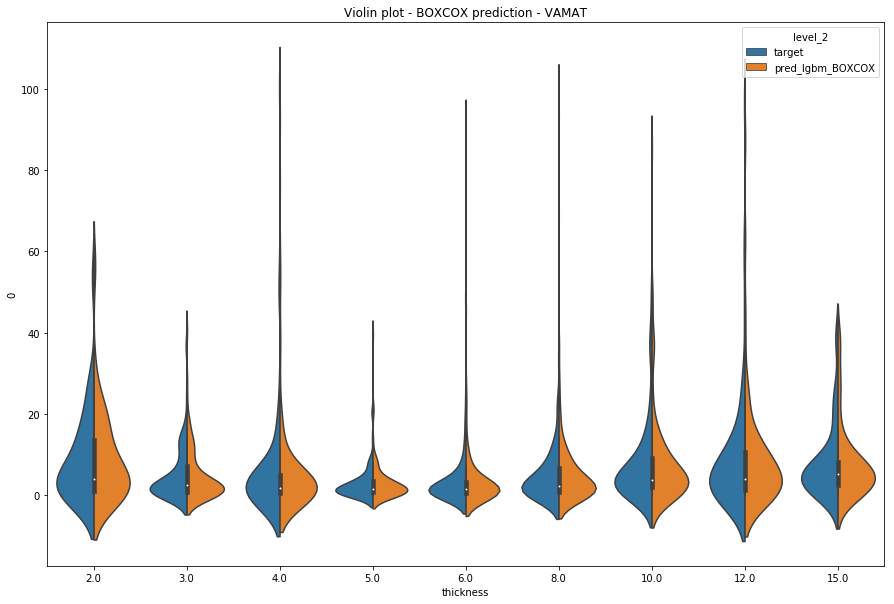

In [70]:
#Violin plot
df=comparisonset[['target', 'pred_lgbm_BOXCOX', 'COART', 'thickness']]
#df=df[df['thickness']!=15]
df.set_index(['COART', 'thickness'], inplace=True)
df = df.stack().reset_index()
fig, ax = plt.subplots(figsize=(15,10))
sns.violinplot(x="thickness", y=0, data=df, split=True, hue='level_2', ax=ax)
plt.title(f'Violin plot - BOXCOX prediction - {target}')
plt.show()

/Users/cricket/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


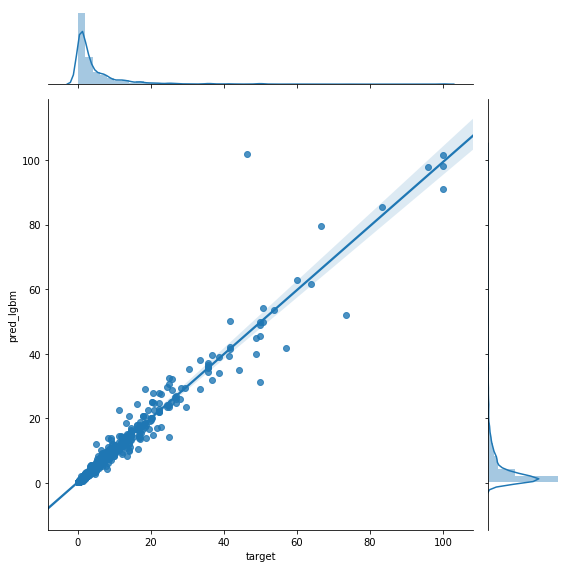

In [71]:
# No BOXCOX
sns.jointplot(x='target', y='pred_lgbm', data=comparisonset, kind='reg', size=8, stat_func=None)
plt.show()

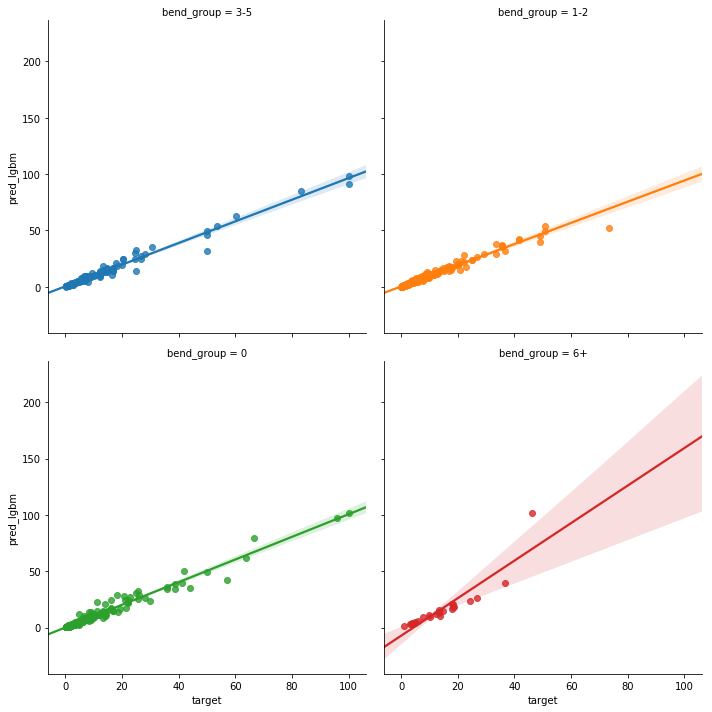

In [72]:
sns.lmplot(x='target',
           y='pred_lgbm',
           col='bend_group',
           hue='bend_group',
           data=comparisonset,
           aspect=1,
           col_wrap=2,
           size=5,
           legend=True)
plt.show()

/Users/cricket/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


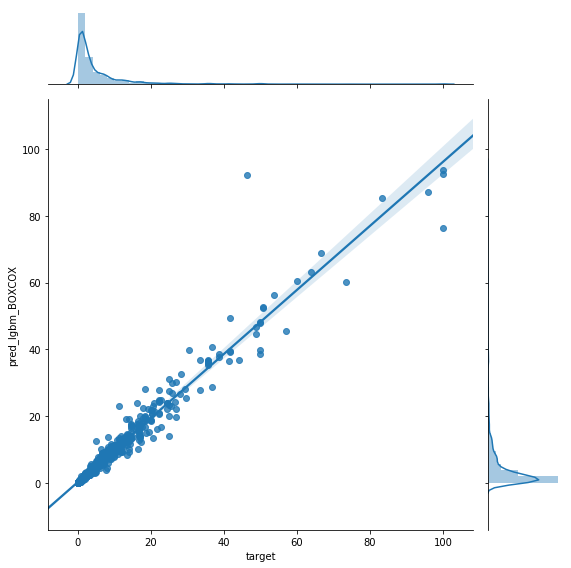

In [73]:
# With BOXCOX
sns.jointplot(x='target', y='pred_lgbm_BOXCOX', data=comparisonset, kind='reg',size=8, stat_func=None)
plt.show()

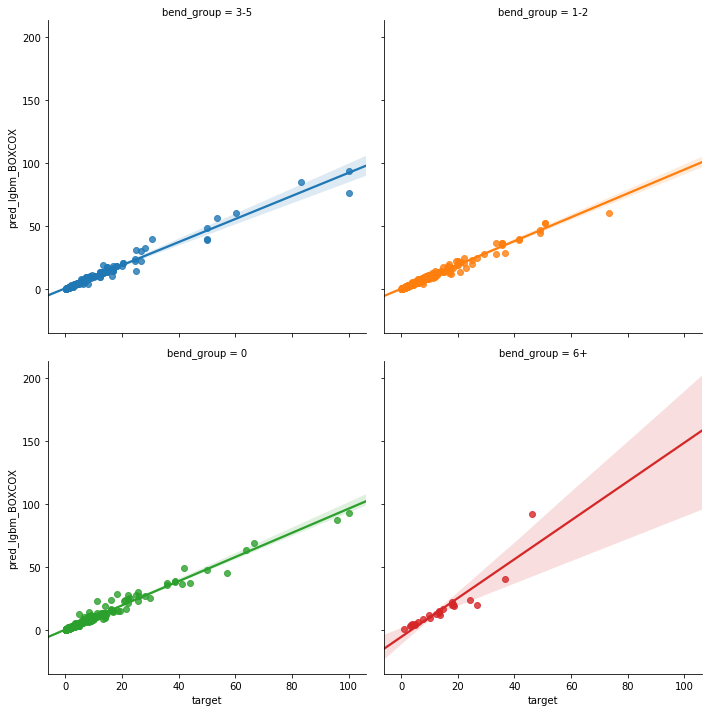

In [74]:
sns.lmplot(x='target',
           y='pred_lgbm_BOXCOX',
           col='bend_group',
           hue='bend_group',
           data=comparisonset,
           aspect=1,
           col_wrap=2,
           size=5,
           #palette="Set1",
           legend=True),
plt.show()

In [75]:
df = comparisonset[['MSE_lgbm', 'COART', 'thickness']]
df.set_index('COART', inplace=True)
worst = df.groupby('thickness')['MSE_lgbm'].nlargest(5)

#worst.to_csv(f'../Y3 - Sample data/Z3 - {target}-outliers.csv')
print(worst.shape)
worst

(45,)


thickness  COART   
2.0        L6020230       8.792687
           L7067210       8.578715
           L6010240       6.184797
           L7012180       3.746886
           L5606461       3.526639
3.0        L8037510      24.124388
           L3122460       8.645696
           L1608760       7.290052
           L7035910       5.959236
           L7016950       5.924200
4.0        L6707490     350.443053
           L1608630      80.505062
           L8411820      37.991229
           L8807311      29.811077
           L8055410      19.998672
5.0        L8834370      21.909699
           L7013792      21.415791
           L7013791      21.198659
           L3101780       8.009616
           L6808600       2.201842
6.0        L7065230    3093.730383
           L8045330     465.968139
           L6005820     115.788263
           L7026890      81.893037
           L6000550      65.485163
8.0        L2608460     163.128158
           L8024970      57.902827
           L8049000      49.397859


In [76]:
comparisonset['delta_log'] = comparisonset['target'] - comparisonset['pred_lgbm_BOXCOX']


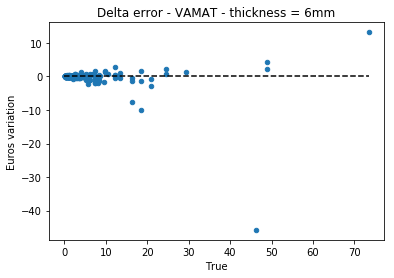

,delta_log
count,316.000000
mean,-0.169056
std,2.827272
min,-45.733154
25%,-0.078470
50%,-0.006754
75%,0.059096
max,13.144116


In [77]:

thickness = 6

df = comparisonset[comparisonset['thickness']==thickness]

df.plot.scatter('target', 'delta_log')
plt.plot([0, df['target'].max()], [0, 0], color='k', linestyle='--')
plt.title('Delta error - {} - thickness = {}mm'.format(target, thickness))
plt.xlabel('True')
plt.ylabel('Euros variation')
plt.show()
df[['delta_log']].describe()

In [78]:
comparisonset[['COART', 'pred_lgbm_BOXCOX', 'target', 'thickness', 'bend_group']].to_csv(f'../Y3 - Sample data/Z4 - {target}-predictions.csv')

In [79]:
df.shape
#df[['delta_log', 'target', 'pred_lgbm_BOXCOX']]

(316, 677)

In [80]:
#comparison

#Thickness filter
df = comparisonset[comparisonset['thickness'] == 8]

#Cost filter Max
#df = df[df[target]<15]

#Cost filter Min
#df = df[df[target]>10] #bend_count

#Min rectangle area
#df = df[df['minimum_rectangle_area'] < 700000]
df = df[df['minimum_rectangle_area'] > 10000]

#bend_count filter
df = df[df['bend_count'] == 4]

#df[df['COART']=='L3128890'].T
df.T

,490,535,562,593,702,738
COART,L3070880,L3108010,L2509970,L2609180,L2512260,L2607650
pred_lgbm,7.32926,2.29324,2.87137,98.0975,2.14242,19.4893
pred_lgbm_BOXCOX,7.33403,2.35664,2.6591,93.8452,2.09781,18.572
target,7.21,2.6,2.6,100.08,2,20.02
MSE_lgbm,0.0142235,0.0941011,0.0736424,3.93022,0.0202839,0.281691
MSE_log_lgbm,0.0153831,0.0592219,0.00349338,38.8724,0.00956773,2.09675
cut_length,2099.71,1065.71,1323.45,18804.5,1143.75,3137.92
num_closed_patterns,3,7,4,173,3,3
num_open_patterns,0,0,0,0,0,0
total_area,54361.4,25374.2,43451.9,1.64351e+06,36513.2,113772


In [81]:
dataset.loc[['L8835850']].T
#comparisonset[comparisonset['COART'] == 'L3131690']

COART,L8835850
cut_length,6989.19
num_closed_patterns,19
num_open_patterns,0
total_area,196112
minimum_rectangle_area,626653
minimum_rectangle_dim1,1322.67
minimum_rectangle_dim2,473.779
convex_hull_area,530068
no_hole_area,221461
thickness,8


# Official set creation

In [82]:
for target in ['VAMAT', 'VALAJOUT']:
    limitedset = ['cut_length', 'num_closed_patterns', 'num_open_patterns', 'total_area', 'minimum_rectangle_area',
              'minimum_rectangle_dim1', 'minimum_rectangle_dim2', 'convex_hull_area', 'no_hole_area', 'weight']

    # 1 Bend as a float
    limitedset.append('thickness')

    # 3 Different counts
    limitedset.extend(['radius_count', 'direction_count', 'bend_count'])

    # 6 according DXF, sorted by length
    if target != 'VAMAT':
        limitedset.extend([x for x in dataset.columns.values if x.startswith('bendlength_')])
    limitedset.append(target)
    df = dataset[limitedset].reset_index().drop('COART', axis=1)
    df.to_csv(f'../Y3 - Sample data/Z5 - {target}_dataset.csv')